# Segmenting interlayers

## Content

* [Problem description](#description)
* [Dataset](#dataset)
* [Model architecture](#architecture)
* [Training](#training)
* [Validation](#validation)
* [Criticism](#criticism)
* [Conclusion](#conclusion)
* [Suggestions for improvements](#suggestions)

<a id='description'></a>

# Problem description
In this notebook we train a neural network for multiclass-segmentation of *seismic interlayers*. Seismic interlayer is a layer of earth formation between two horizons. It is though to have roughly similar seismic reflection parameters across all of its volume. As the result, convolutional neural network models, trained on a small subset of *ilines/xlines* are expected to classify interlayers on unseen (during training) parts of seismic cubes.

In [ ]:
import sys
import os

In [ ]:
sys.path.append('../repos/seismiqb/')

In [ ]:
import numpy as np
%env CUDA_VISIBLE_DEVICES=5

<a id='dataset'></a>

# Dataset
we use one seismic cube `P_cube` for training/testing. One can find [here]() a description of cube `P_cube` along with some visualiztions. Importantly, for training and testing we use different sets of *ilines*: 45% of *ilines* are reserved for training while 35% of *ilines* are used for testing (we intentionally use a margin of *ilines* between training and testing parts to battle overfit).

* Indexing seismic cubes: setting up `SeismicCubeset`

In [97]:
from seismiqb import SeismicCropBatch, SeismicCubeset
from seismiqb.batchflow import FilesIndex, D, L, F, Pipeline, B, V

In [98]:
from seismiqb import make_labels_dict

In [99]:
DATA_DIR = '/notebooks/data/cubes/CUBE_3/'

In [100]:
qbix = FilesIndex(path=os.path.join(DATA_DIR, 'P_cube.hdf5'), no_ext=True)
qbset = SeismicCubeset(qbix)

* load info about seismic cubes into `SeismicCubeset`

In [101]:
qbset.load_geometries()

* load horizon-labels

In [102]:
pref = os.path.join(DATA_DIR, 'HORIZONTS')
horizons_paths = [os.path.join(pref, p) for p in ['prb_B_anon.txt',
                                                  'prb_T_ALL_anon.txt',
                                                  'prb_G_anon.txt',
                                                  'prb_M_anon.txt']]

In [103]:
qbset.load_point_clouds(paths={qbset.indices[0]: horizons_paths})

In [104]:
qbset.load_labels()

* make train/test samplers

In [105]:
qbset.load_samplers()

In [106]:
qbset.train_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                            high=[1, 0.45, 1]).sample
qbset.test_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                           low=[0, 0.65, 0]).sample

* `pipeline` for loading cube crops and building segmentation-masks

In [115]:
wflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('train_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).swapaxes(1, 2).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

<a id='architecture'></a>

# Model architecture
We use a convolutional neural network [`U-net`](https://arxiv.org/abs/1505.04597) for interlayers segmentation.

In [118]:
from seismiqb.batchflow.models.tf import UNet
from tqdm import trange
from IPython.display import clear_output

* configuring `unet`

In [119]:
config = {'inputs': dict(cubes={'shape': (128, 128, 1)},
                         masks={'name': 'targets', 'shape': (128, 128),
                                'classes': 10, 'transform': 'ohe'}),
          'initial_block/inputs': 'cubes',
          'loss': 'dice',
          'head': dict(num_classes=10),
          'optimizer': 'Adam'}

<a id='training'></a>

# Training
`U-net` is trained of 2d-crops of seismic cubes of size `[128, 128]`. The training-procedure uses `Adam`-optimizer and is performed on batches of 32 crops.

In [120]:
trainflow = wflow + (Pipeline()
                     .init_variable('loss', default=list())
                     .init_model('static', UNet, 'model', config)
                     .train_model('model',
                                  feed_dict={'cubes': B('cubes'),
                                  'masks': B('masks')},
                                  fetches='loss', save_to=V('loss'), mode='a'))

In [121]:
pset = (qbset >> trainflow)

In [ ]:
N_ITERS = 300
tr = trange(N_ITERS, leave=True)
for i in tr:
    pset.next_batch(1, n_epochs=None)
    tr.set_description("current loss is {}".format(pset.get_variable('loss')[-1]))
    clear_output()

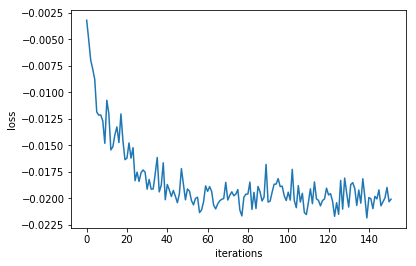

In [129]:
plt.plot(pset.get_variable('loss'))
plt.xlabel('iterations'), plt.ylabel('loss')
plt.show()

# Validation

In this section we look at predictions of our model on *ilines* of the cube we haven't used for training.

In [ ]:
from utils import get_lines_range

In [124]:
tflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('test_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

In [125]:
test_batch = (qbset >> tflow).next_batch(1)

In [126]:
import tensorflow as tf

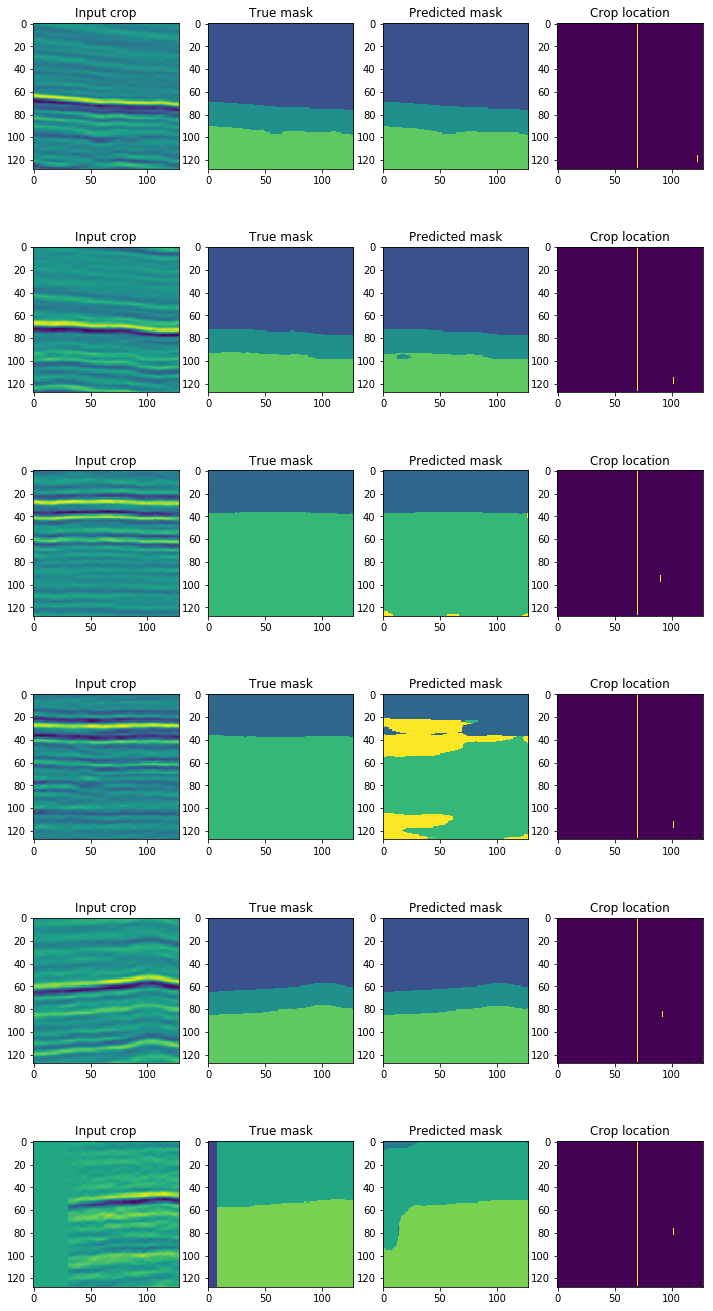

In [134]:
unet = pset.get_model_by_name('model')
targets, predictions = unet.predict(fetches=['targets', tf.nn.softmax(unet.predictions)],
                                    feed_dict={unet.cubes: test_batch.cubes, unet.masks: test_batch.masks})
n_rows = 6
figs, axes = plt.subplots(n_rows, 4, figsize=(3 * 4, n_rows * 4))
for i, nr in enumerate([1, 2, 3, 4, 5, 7]):
    vmin, vmax = np.min(targets.argmax(axis=-1)[nr,...]) - 1, np.max(targets.argmax(axis=-1)[nr,...]) + 1
    axes[i, 0].imshow(test_batch.cubes[nr,...,0].T)
    axes[i, 1].imshow(targets.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)
    axes[i, 2].imshow(predictions.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)

    axes[i, 0].set_title('Input crop')
    axes[i, 1].set_title('True mask')
    axes[i, 2].set_title('Predicted mask')
    axes[i, 3].set_title('Crop location')
    
    ir, xr = get_lines_range(test_batch, nr)
    ir = np.round([128 * ir[0], 128 * ir[1]]).astype(np.int32)
    xr = np.round([128 * xr[0], 128 * xr[1]]).astype(np.int32)
    locs = np.zeros((128, 128), dtype=np.float64)
    locs[ir[0]:ir[1], xr[0]:xr[1] + 1] = 1
    locs[0:-1, np.int(0.55 * 128)] = 1
    axes[i, 3].imshow(locs)

# Criticism

# Conclusion

# Suggestions for improvments